Rayleigh-Taylor instability
======

This notebook models the Rayleigh-Taylor instability outlined in van Keken *et al.* (1997). The model dimension is 0.9142 $\times$ 1. The boundary condition is nonslip on the top and bottom, and free slip on both sides.

The system of equations is given by

$$\nabla \cdot \left( \eta \dot\varepsilon \right) - \nabla p = -R_b \Gamma \mathbf{\hat z}$$
and, 
$$\nabla \cdot \mathbf{v} = 0 $$

, where $R_b$ is composisional Rayleigh number, $\Gamma$ the composision, $\mathbf{\hat z}$ a unit vector in the direction of gravity (See van Keken et al., 1997 for more details).


**Keywords:** particle swarms, Stokes system, advective diffusive systems

<table><tr><td><img src='./input/rt_init.png'></td><td><img src='./input/rt_822.png'></td></tr></table>
Initial model composision (Left), and model composision at dimernsionless time 822 (Right) for the case where viscosity contrast is 100 fold, i.e., viscosity for blue composision is 1., and 0.01 for orange. 

**References**

van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np

/Users/glwu/underworld/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Setup parameters
-----

In [2]:
# physical parameters
boxLength      = 0.9142
boxHeight      = 1.0
viscosityRatio = 1.

# output
inputPath  = 'input/'
outputPath = 'test/'

# numerical parameters - demo or 'longtest'
# demo       - settings for a quick run (iff longtest is False)
# 'longtest' - settings for benchmark

longtest = False

model_end_time   = 500.
res              = 64
stokes_inner_tol = 1e-6 # Sovler configuration
stokes_outer_tol = 1e-5 # Sovler configuration
# users ignore
import os
if "UW_LONGTEST" in os.environ or longtest:
    # to capture the peak V_rms (benchmark) set model_end_time~220
    # the peak V_rms. 
 
    model_end_time   = 2000
    res              = 128
    stokes_inner_tol = 1e-7
    stokes_outer_tol = 1e-5
    

In [3]:
# Make output directory if necessary
if uw.rank()==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

Create mesh and finite element variables
------

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField = mesh.add_variable(         nodeDofCount=2 )
pressureField = mesh.subMesh.add_variable( nodeDofCount=1 )

# initialise 
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Create a particle swarm
------

In [5]:
# Create a swarm
swarm = uw.swarm.Swarm( mesh=mesh )

# Create a data variable. It will be used to store the material index of each particle
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

# create population control object
particleControls = uw.swarm.PopulationControl(swarm, aggressive = True, splitThreshold=0.3,
                            maxDeletions = 15, maxSplits =50, particlesPerCell = 20)

Initialise each particle's material index
-----

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# material perturbation from van Keken et al. 1997
wavelength = 2.0*boxLength
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

# Define the material perturbation, a function of the x coordinate
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0] )

# If z is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle
# Results are written to the materialIndex swarm variable
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Plot the particles by material**


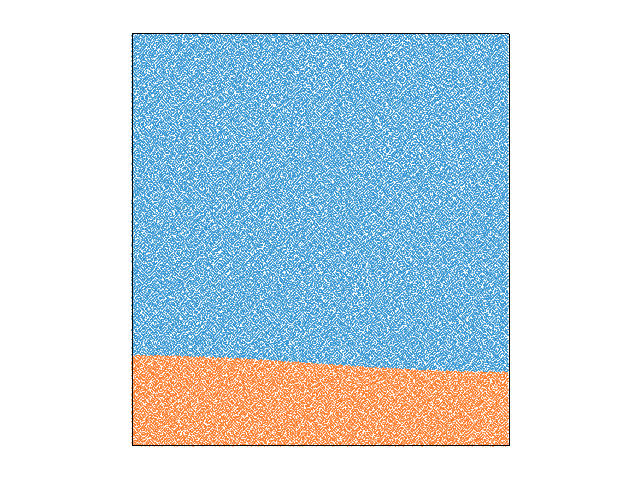

In [7]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Points(swarm, materialIndex, pointSize=2, colourBar=False) )
fig1.show()

Map properties to material index
-----
The Map function allows us to create 'per material' type behaviour. Again we use the branching function to set up a (condition, action) command. 

In [8]:
# Set a density of '0.' for light material, '1.' for dense material. Note density map here really mean 'Rb Gamma'
densityMap   = { lightIndex:0., denseIndex:1. }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials
viscosityMap = { lightIndex:viscosityRatio, denseIndex:1. }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*z_hat

Boundary conditions
-----

Create free-slip condition on the vertical boundaries, and a no-slip condition on the horizontal boundaries.

In [9]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
allWalls = iWalls + jWalls

# Prescribe degrees of freedom on each node to be considered Dirichlet conditions
# In the x direction on allWalls flag as Dirichlet
# In the y direction on jWalls (horizontal) flag as Dirichlet
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (allWalls, jWalls) )

Create systems
-----

In [10]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.nProcs()==1):
    solver.set_inner_method("lu")
#     solver.set_penalty(1.0e6) 
# solver.set_inner_rtol = stokes_inner_tol
solver.set_outer_rtol = stokes_outer_tol

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Time stepping
-----

In [11]:
# Initialise time and timestep
time = 0.
step = 0

# parameters for output
outputEvery  = 20
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(outputPath+"Mesh.h5")

In [12]:
# define an update function
def update():
    dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system
    if dt > 5.:
        dt = 5.
    advector.integrate(dt)     # advect step
    # Particle control
    particleControls.repopulate()
    return time+dt, step+1, dt

In [13]:
dt = 0.
while time < model_end_time:

    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.rank()==0):
        vrmsVal.append(vrms)
        timeVal.append(time)
    
    # Output to disk
    if step%outputEvery == 0:
        if(uw.rank()==0):
            print('step = {0:6d}; time = {1:.3e}; dt = {2:.3e}; v_rms = {3:.3e}'.format(step,time,dt,vrms))

        filename = outputPath+"/velocityField."+str(step)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"/pressureField."+str(step)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str('{:5.2f}'.format(time)).zfill(4) # Name image with time
        fig1.save_image(outputFilename)

    # We are finished with current timestep, update.
    time, step, dt = update()
    
if(uw.rank()==0):
    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

step =      0; time = 0.000e+00; dt = 0.000e+00; v_rms = 1.833e-04
step =     20; time = 1.000e+02; dt = 5.000e+00; v_rms = 6.024e-04
step =     40; time = 1.536e+02; dt = 1.562e+00; v_rms = 1.502e-03
step =     60; time = 1.775e+02; dt = 9.861e-01; v_rms = 2.298e-03
step =     80; time = 1.949e+02; dt = 7.980e-01; v_rms = 2.862e-03
step =    100; time = 2.101e+02; dt = 7.396e-01; v_rms = 3.124e-03
step =    120; time = 2.250e+02; dt = 7.534e-01; v_rms = 3.071e-03
step =    140; time = 2.407e+02; dt = 8.286e-01; v_rms = 2.763e-03
step =    160; time = 2.587e+02; dt = 9.727e-01; v_rms = 2.353e-03
step =    180; time = 2.801e+02; dt = 1.164e+00; v_rms = 1.954e-03
step =    200; time = 3.056e+02; dt = 1.389e+00; v_rms = 1.613e-03
step =    220; time = 3.355e+02; dt = 1.603e+00; v_rms = 1.371e-03
step =    240; time = 3.699e+02; dt = 1.827e+00; v_rms = 1.170e-03
step =    260; time = 4.089e+02; dt = 2.061e+00; v_rms = 1.011e-03
step =    280; time = 4.533e+02; dt = 2.381e+00; v_rms = 8.499

Post simulation analysis
-----


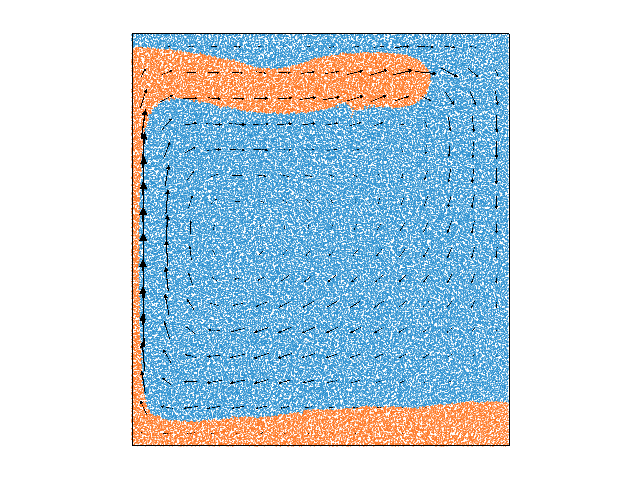

In [14]:
fig1.append( glucifer.objects.VectorArrows( mesh, velocityField))
fig1.show()

Viscosity ratio = 1.00
    t(max vrms) = 214.56
           vrms = 0.0031


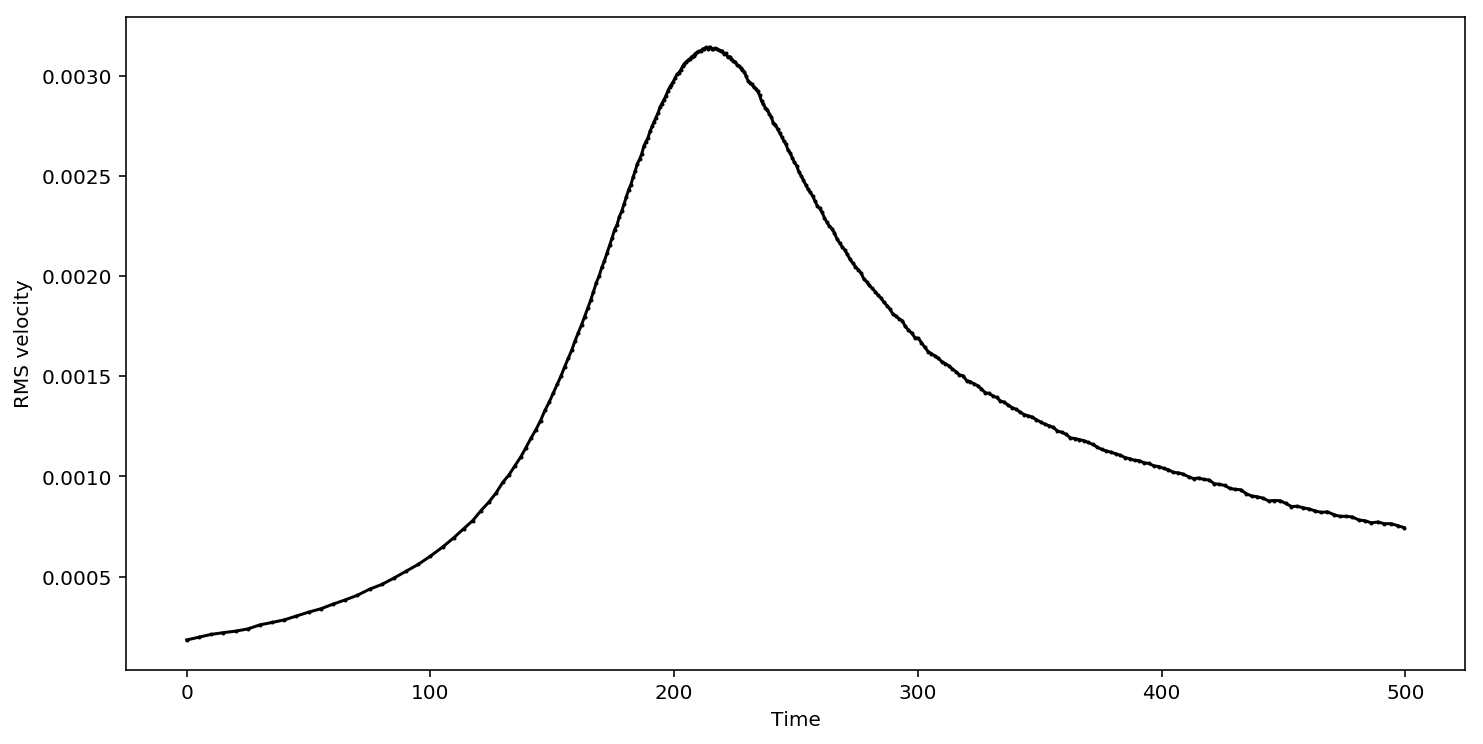

In [15]:
# if longtest == False:
#     # This cell is for testing purposes. It ensures the example computes the expected flow velocity rms values
#     if not np.isclose(stokes.velocity_rms(), 1.83340219912e-4):
#         raise RuntimeError("The Velocity RMS {} is not close to expected value".format(stokes.velocity_rms()))

# import os
# os.write(1, "Vrms is {:.5e} \n".format(stokes.velocity_rms()))

if(uw.rank()==0):
    
    maxIndex = np.argmax(vrmsVal)

    print('Viscosity ratio = {0:.2f}'.format(viscosityRatio))
    print('    t(max vrms) = {0:.2f}'.format(timeVal[maxIndex]))
    print('           vrms = {0:.4f}'.format(vrmsVal[maxIndex]))
    
    # output a summary file with benchmark values. The benchmark values are listed
    # in table 1 in van Keken *et al.* 1997.
    np.savetxt(outputPath+'summary.txt', [viscosityRatio, timeVal[maxIndex], vrmsVal[maxIndex]])
    
    # Save time and root mean square velocity to a file
    t = np.array(timeVal) # time
    v = np.array(vrmsVal) # root mean square velocity
    vEvol = np.vstack((t,v))
    np.savetxt(outputPath + 'vrms.txt',vEvol.T)
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    fig = plt.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    # ax.plot(timeCompare, vrmsCompare, color = 'black') 
    ax.plot(timeVal, vrmsVal, color = 'k', marker='.', markersize=2) 
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS velocity')
#     ax.set_xlim([0.0,2000.0])

**Plot RMS velocity for 3 cases**

Note that the viscosity ratio are 1., 0.1, and 0.01, for case A, B, and C, respectively. All models were run at resolution of 64 $\times$ 64.

(0.0, 0.015)

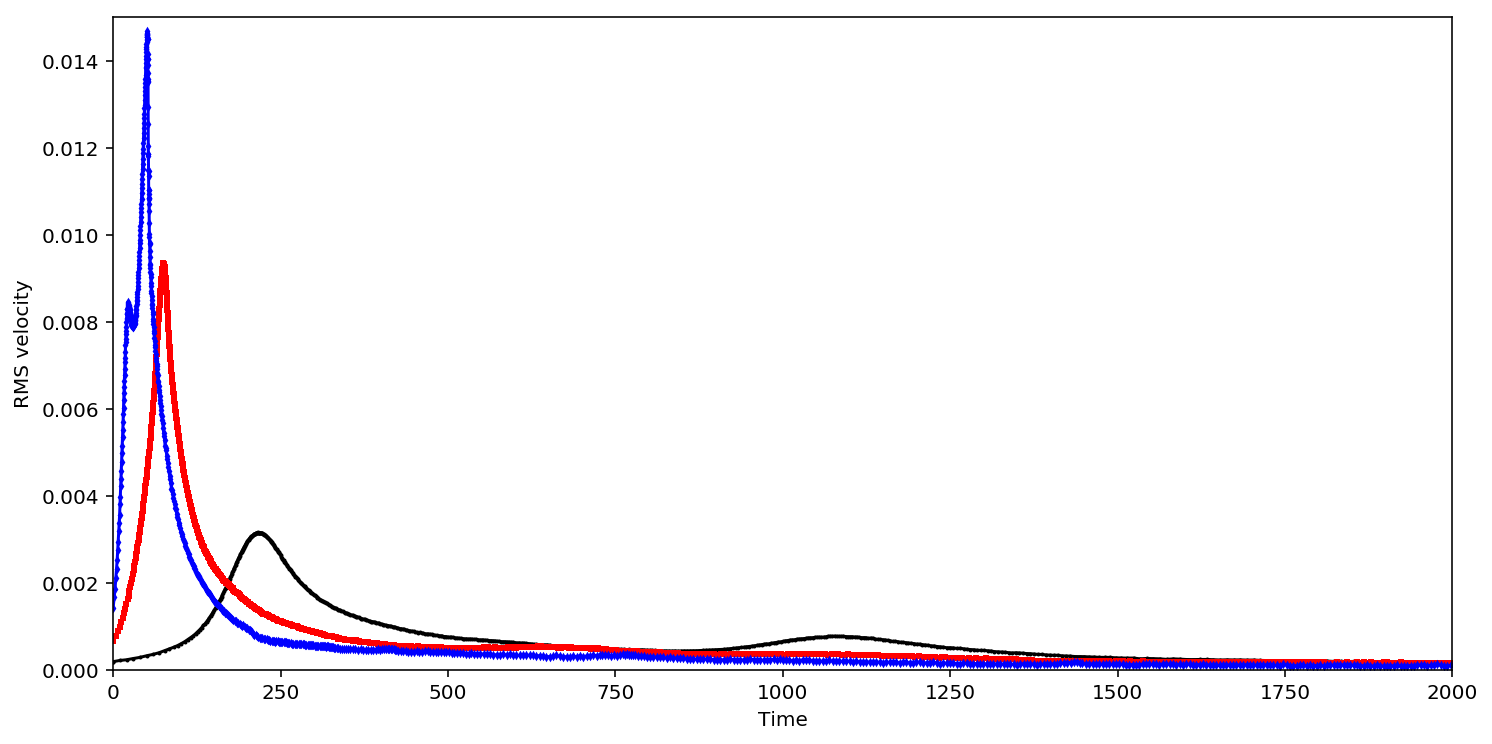

In [16]:
if uw.rank() == 0:
    vA = np.loadtxt(inputPath+'Vrms_CaseA.txt')
    vB = np.loadtxt(inputPath+'Vrms_CaseB.txt')
    vC = np.loadtxt(inputPath+'Vrms_CaseC.txt')

fig = plt.figure()
fig.set_size_inches(12, 6)
ax = fig.add_subplot(1,1,1)
ax.plot(vA[:,0], vA[:,1], color = 'k', marker='.', markersize=2)
ax.plot(vB[:,0], vB[:,1], color = 'r', marker='s', markersize=2) 
ax.plot(vC[:,0], vC[:,1], color = 'b', marker='d', markersize=2) 
ax.set_xlabel('Time')
ax.set_ylabel('RMS velocity')
ax.set_xlim([0.0,2000.0])
ax.set_ylim([0.0,.015])